## Case Study: Clustering

### Problem Statement:
To categorize the professionals into relevant groups based on their company, designation and years of experience.Based on the categorization, determine the top companies and job roles. To determine, the scope for upskilling and better oppurtunites based on the clusters formed.

In [383]:
#Import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
import datetime
from sklearn.neighbors import NearestNeighbors
from random import sample
from sklearn.cluster import KMeans
from sklearn.manifold import MDS
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
import math

In [384]:
#Set max columns to display and max column width to be displayed

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth',100)
sns.set_style('darkgrid')

In [385]:
#Import the data into the dataframe

df = pd.read_csv('train.csv')

### EDA

In [386]:
#Check shape of the data

df.shape

(205843, 7)

In [387]:
#Get the glimpse of the data

df.head()

,Unnamed: 0,company_hash,email_hash,orgyear,ctc,job_position,ctc_updated_year
0,0,atrgxnnt xzaxv,6de0a4417d18ab14334c3f43397fc13b30c35149d70c050c0618caea697c87af,2016.0,1100000,Other,2020.0
1,1,qtrxvzwt xzegwgbb rxbxnta,b0aaf1ac138b53cb6e039ba2c3d6604a250d02d5145c100a9661a92bdcc0407b,2018.0,449999,FullStack Engineer,2019.0
2,2,ojzwnvwnxw vx,4860c670bcd48fb96c02a4b0ae3608ae6fdd98176112e90fd66c9df6b37b9059,2015.0,2000000,Backend Engineer,2020.0
3,3,ngpgutaxv,effdede7a2e7c2af664c8a31d9346385016128d66bbc58a44274d5d6876dfec7,2017.0,700000,Backend Engineer,2019.0
4,4,qxen sqghu,6ff54e709262f55cb999a1c1db8436cb2055d8f79ab520214b31b95211adb095,2017.0,1400000,FullStack Engineer,2019.0


In [388]:
#Drop the unwanted column

df = df.drop(['Unnamed: 0'], axis=1)

In [389]:
#Check if any missing values and column datatypes

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205843 entries, 0 to 205842
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   company_hash      205799 non-null  object 
 1   email_hash        205843 non-null  object 
 2   orgyear           205757 non-null  float64
 3   ctc               205843 non-null  int64  
 4   job_position      153281 non-null  object 
 5   ctc_updated_year  205843 non-null  float64
dtypes: float64(2), int64(1), object(3)
memory usage: 9.4+ MB


In [390]:
#Check for missing values

df.isna().sum()

company_hash           44
email_hash              0
orgyear                86
ctc                     0
job_position        52562
ctc_updated_year        0
dtype: int64

In [391]:
#Since number of missing values in company hash are very less, we are dropping those

df = df.loc[~df['company_hash'].isna()]
df.isna().sum()/len(df)*100

company_hash         0.000000
email_hash           0.000000
orgyear              0.041788
ctc                  0.000000
job_position        25.525391
ctc_updated_year     0.000000
dtype: float64

In [392]:
#Since the number of missing values in the orgyear are very less, we are dropping those

df = df.loc[~df['orgyear'].isna()]
df.isna().sum()/len(df)*100

company_hash         0.000000
email_hash           0.000000
orgyear              0.000000
ctc                  0.000000
job_position        25.524396
ctc_updated_year     0.000000
dtype: float64

In [393]:
#Dropping the records with blank job position since those are very few (just two rows)

df = df.loc[~(df['job_position']=='')]
df = df.reset_index()
df = df.drop(['index'], axis=1)

### Regex for cleaning job_position names

In [394]:
#Define a function to perform text cleaning using regex on the column job_position

def regex(x):
    res = re.sub('[^A-Za-z0-9 ]+', '', x)
    res = re.sub(' +', ' ', res)
    res = re.sub(' 2', ' II', res)
    res = re.sub(' 1', ' I', res)
    res = re.sub(' 3', ' III', res)
    res = re.sub(' 4', ' IV', res)
    res = re.sub('APPLICATIONS ', 'APPLICATION ', res)
    res = re.sub('ASE', 'ASSISTANT SYSTEM ENGINEER', res)
    res = re.sub('ENGINNER', 'ENGINEER', res)
    res = re.sub('PROCESSOR', 'PROFESSOR', res)
    res = re.sub('ENGINEERTRAINEE', 'ENGINEER TRAINEE', res)
    res = re.sub('TECH ', 'TECHNICAL ', res)
    res = re.sub('ASST ', 'ASSISTANT ', res)
    res = re.sub('ANALYSTS', 'ANALYST', res)
    res = re.sub('COFOUNDERG', 'COFOUNDER', res)
    res = re.sub('CONSULTANAT', 'CONSULTANT',res)
    res = re.sub('ANALAYST', 'ANALYST', res)
    res = re.sub('EINGINEER', 'ENGINEER', res)
    res = re.sub('ASOCIATE', 'ASSOCIATE', res)
    res = re.sub('ENGINEET', 'ENGINEER', res)
    res = re.sub('FRONTEND', 'FRONT END', res)
    res = re.sub('FULLSTACK', 'FULL STACK', res)
    res = re.sub('OPERATION', 'OPERATIONS', res)
    res = re.sub('APPS', 'APPLICATIONS', res)
    res = re.sub('APPLICATION', 'APPLICATIONS', res)
    res = re.sub('DEVELLOPER', 'DEVELOPER', res)
    res = re.sub('SDE1', 'SDE I', res)
    res = re.sub('SDE2', 'SDE II', res)
    res = re.sub('SDE3', 'SDE III', res)
    res = re.sub('SDEI', 'SDE I', res)
    res = re.sub('SDEII', 'SDE II', res)
    res = re.sub('SDET2', 'SDET II', res)
    res = re.sub('SE4', 'SE IV', res)
    res = re.sub('ENGGINEER', 'ENGINEER', res)
    return res

In [395]:
#Convert the job_position into the uppercase letters
#Strip the leading and trailing spaces from the job_positions

df['job_position'] = df['job_position'].str.upper()
df['job_position'] = df['job_position'].str.strip()

In [396]:
#Call the regex function and perform the cleaning of job_position column

for i in range(len(df['job_position'])):
    if isinstance(df['job_position'][i], str):
        df.loc[i, 'job_position'] = regex(df['job_position'][i])

In [397]:
#Check the number of unique job_positions after performing the regex

df['job_position'].nunique()

839

### Univariate, bivariate analysis

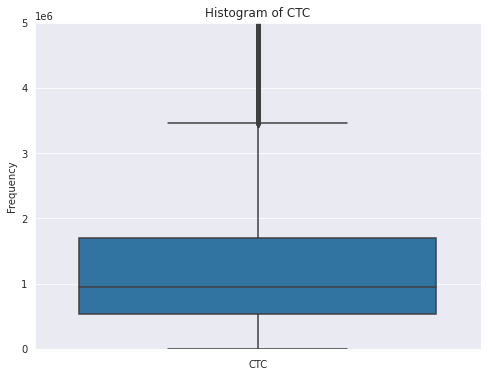

In [398]:
#Perform univariate and bivariate analysis based on the continuous or categorical variable

plt.figure(figsize=(8,6))
sns.boxplot(y=df['ctc'])
plt.xlabel('CTC')
plt.ylim(0,5000000)
plt.ylabel('Frequency')
plt.title('Histogram of CTC')
#plt.grid()
plt.show()

#Inference : Median Salary of professionals is around 10,00000 as per the box plot
#There are many outliers as per the boxplot

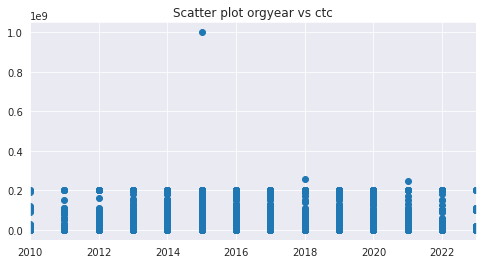

In [399]:
#Scatter plot to see how the CTC varies for orgyear parameter

plt.figure(figsize=(8,4))
plt.scatter(df['orgyear'], df['ctc'])
plt.xlim(2010,2023)
plt.title('Scatter plot orgyear vs ctc')
#plt.grid()
plt.show()

#Inference - For all the years of joining the CTCs of the employees are capped at almost similar amount

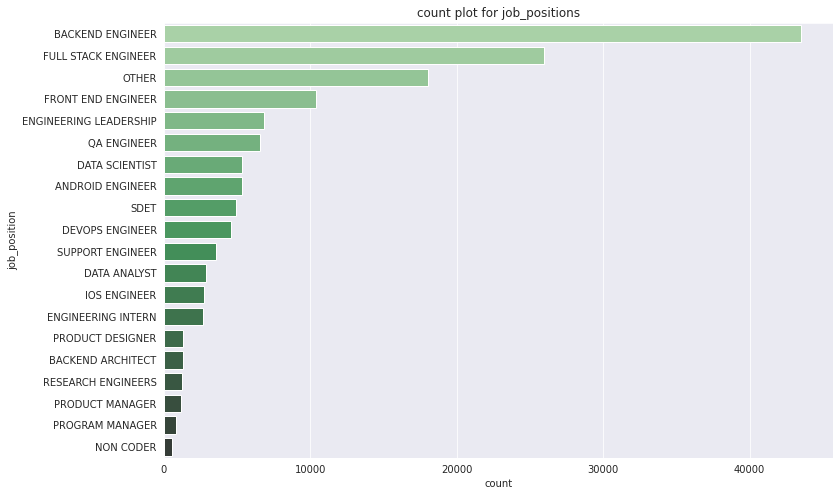

In [400]:
#Count plot for job_positions

plt.figure(figsize=(12,8))
sns.countplot(data=df,
              y='job_position',
              palette='Greens_d',
              order=df.job_position.value_counts().iloc[:20].index)
plt.title('count plot for job_positions')
plt.show()

#Inference - Top 3 job positions are Backend Engr, Full Stack Engr and Other

In [401]:
#Check value count of company hash

df['company_hash'].value_counts()

nvnv wgzohrnvzwj otqcxwto    8335
xzegojo                      5381
vbvkgz                       3480
zgn vuurxwvmrt vwwghzn       3411
wgszxkvzn                    3239
                             ... 
vhngsqxa xzaxv                  1
ctavznh td kteg                 1
ihxwprgsxw ogenfvqt             1
onvqmhwpo                       1
bvptbjnqxu td vbvkgz            1
Name: company_hash, Length: 37274, dtype: int64

In [402]:
#Check value count for email hash

df['email_hash'].value_counts()

bbace3cc586400bbc65765bc6a16b77d8913836cfc98b77c05488f02f5714a4b    10
3e5e49daa5527a6d5a33599b238bf9bf31e85b9efa9a94f1c88c5e15a6f31378     9
298528ce3160cc761e4dc37a07337ee2e0589df251d73645aae209b010210eee     9
6842660273f70e9aa239026ba33bfe82275d6ab0d20124021b952b5bc3d07e6c     9
4818edfd67ed8563dde5d083306485d91d19f4f1c95d193a1700e79dd245b75c     8
                                                                    ..
9a891d279335db60cd6a45c2243bca2c56f940e31c5a812a6f642ea800832c4b     1
e96207e084f4552ba131598c704d2c5f12373999fc66285f58dea00afb9d333c     1
09102244a24ed7ae3beff197e3bfa8402f2d72dc69e1fa5bee18d9fc5d6aeeae     1
bc51538e8265ba631bafe120d53a17ac4aac9232127285e5c9fa09117af2c68f     1
0bcfc1d05f2e8dc4147743a1313aa70a119b41b30d4a1f7e738a6a87d3712c31     1
Name: email_hash, Length: 153333, dtype: int64

### Encoding of categorical variables

In [403]:
#Perform Label encoding of job_position column
#Assumption: Job position is an ordinal categorical variable
#Ordinal because: One job position can be ranked as higher than other

le = LabelEncoder()
df['job_position_encoded'] = le.fit_transform(df['job_position'].values)

In [404]:
#Check for missing value records based on job_position column

df.loc[df['job_position'].isna()].head()

,company_hash,email_hash,orgyear,ctc,job_position,ctc_updated_year,job_position_encoded
8,utqoxontzn ojontbo,e245da546bf50eba09cb7c9976926bd56557d1ac9a17fb019e8de1fdb83fc0d6,2020.0,450000,NaN,2019.0,839
9,xrbhd,b2dc928f4c22a9860b4a427efb8ab761e1ce0015fba1a5e804e1dc27e305b06b,2019.0,360000,NaN,2019.0,839
12,mvqwrvjo wgqugqvnt mvzpxzs,7f24d2f5171ea469482a9966832237bc023678883ecd0c5142677b75a138b2fa,2020.0,800000,NaN,2020.0,839
17,puxn,26b502eb6439ac80bd618a6f7c2b1c640b84c1e64c472cf0510b0b36c2d3c247,2020.0,1400000,NaN,2019.0,839
18,mvlvl exzotqc,62d2e04b44c8bf2f6ec15d5b4c259c06199f598dc51816b1e32a84bc3ed980ea,2018.0,100000,NaN,2021.0,839


In [405]:
#Label encoding had encoded NaN values too.
#Converting the encoded NaN values back to NaNs as we will fill those using KNN imputer

df.loc[df['job_position_encoded']==839, 'job_position_encoded'] = np.nan

In [406]:
#Verify if the NaN values are back in encoded job_position column

df.loc[df['job_position'].isna()].head()

,company_hash,email_hash,orgyear,ctc,job_position,ctc_updated_year,job_position_encoded
8,utqoxontzn ojontbo,e245da546bf50eba09cb7c9976926bd56557d1ac9a17fb019e8de1fdb83fc0d6,2020.0,450000,NaN,2019.0,NaN
9,xrbhd,b2dc928f4c22a9860b4a427efb8ab761e1ce0015fba1a5e804e1dc27e305b06b,2019.0,360000,NaN,2019.0,NaN
12,mvqwrvjo wgqugqvnt mvzpxzs,7f24d2f5171ea469482a9966832237bc023678883ecd0c5142677b75a138b2fa,2020.0,800000,NaN,2020.0,NaN
17,puxn,26b502eb6439ac80bd618a6f7c2b1c640b84c1e64c472cf0510b0b36c2d3c247,2020.0,1400000,NaN,2019.0,NaN
18,mvlvl exzotqc,62d2e04b44c8bf2f6ec15d5b4c259c06199f598dc51816b1e32a84bc3ed980ea,2018.0,100000,NaN,2021.0,NaN


In [407]:
#Perform Label encoding of company_hash column
#Assumption: company is an ordinal categorical variable
#Ordinal because: One company can be ranked as higher than other on variety of parameters

le = LabelEncoder()
df['company_hash_encoded'] = le.fit_transform(df['company_hash'].values)

In [408]:
#Feature Engineering
#Years of Experience created as new column

df['Years of Experience'] = datetime.date.today().year - df['orgyear']

In [409]:
#Create a new copy of encoded dataframe and drop the original values
#Creating new df for further proceedings

df1 = df.copy()
df1 = df1.drop(['company_hash','job_position','email_hash'], axis=1)

### Missing value treatment using KNN Imputation

In [410]:
#Perform KNN imputation to fill the missing values in job_position column

knn = KNNImputer(n_neighbors=3)
df1_imputed = knn.fit_transform(df1)

df1_imputed_frame = pd.DataFrame(df1_imputed, columns=df1.columns)
df1_imputed_frame['job_position_encoded'] = df1_imputed_frame['job_position_encoded'].round()

In [411]:
# dum = df.groupby(['company_hash', 'job_position']).filter(lambda x: len(x) >= 1)

In [413]:
#Get the glimpse of an imputed dataframe

df1_imputed_frame.head()

,orgyear,ctc,ctc_updated_year,job_position_encoded,company_hash_encoded,Years of Experience
0,2016.0,1100000.0,2020.0,409.0,968.0,7.0
1,2018.0,449999.0,2019.0,249.0,19711.0,5.0
2,2015.0,2000000.0,2020.0,108.0,15498.0,8.0
3,2017.0,700000.0,2019.0,108.0,12099.0,6.0
4,2017.0,1400000.0,2019.0,249.0,20207.0,6.0


### Creation of tier based on comapny groupings w.r.t. CTC

In [414]:
#Group by the companies by CTC and use describe() method to get the stats
#Stats such as - 25, 50 and 75 percentile of the salary
#This company level CTC will be used for creating the tiers in later steps

temp = df1_imputed_frame.groupby(['company_hash_encoded'])['ctc'].describe()
temp1 = temp.reset_index().drop(['count','mean','std','min','max'],axis=1)
temp1.head()

,company_hash_encoded,25%,50%,75%
0,0.0,100000.0,100000.0,100000.0
1,1.0,300000.0,300000.0,300000.0
2,2.0,410000.0,550000.0,690000.0
3,3.0,1100000.0,1100000.0,1100000.0
4,4.0,137500.0,175000.0,212500.0


In [415]:
#Merge the original dataframe with the grouped dataframe

df1_imputed_frame = pd.merge(df1_imputed_frame, temp1,on='company_hash_encoded',how='left')

In [416]:
#Create company tier column with all zeros

df1_imputed_frame['company_tier'] = np.zeros(df1_imputed_frame.shape[0])

In [417]:
#Records with CTC higher than 75% of their company's CTC are marked as tier 1.0

df1_imputed_frame.loc[(df1_imputed_frame['ctc'] > df1_imputed_frame['75%']) 
                      & (df1_imputed_frame['company_tier']==0), 'company_tier'] = 1.0

In [418]:
#Records with CTC higher than 50% and lower than 75% of their company's CTC are marked as tier 2.0

df1_imputed_frame.loc[(df1_imputed_frame['ctc'] >= df1_imputed_frame['50%']) 
                      & (df1_imputed_frame['company_tier']==0), 'company_tier'] = 2.0

In [419]:
#Records with CTC less than the 50% of their company's CTC are marked as tier 3.0

df1_imputed_frame.loc[(df1_imputed_frame['ctc'] < df1_imputed_frame['50%']) 
                      & (df1_imputed_frame['company_tier']==0), 'company_tier'] = 3.0

In [420]:
#Get the glimpse of the dataframe after company tier creation

df1_imputed_frame.head()

,orgyear,ctc,ctc_updated_year,job_position_encoded,company_hash_encoded,Years of Experience,25%,50%,75%,company_tier
0,2016.0,1100000.0,2020.0,409.0,968.0,7.0,800000.0,1070000.0,1500000.0,2.0
1,2018.0,449999.0,2019.0,249.0,19711.0,5.0,600000.0,900000.0,1688750.0,3.0
2,2015.0,2000000.0,2020.0,108.0,15498.0,8.0,2000000.0,2000000.0,2000000.0,2.0
3,2017.0,700000.0,2019.0,108.0,12099.0,6.0,1100000.0,1400000.0,2000000.0,3.0
4,2017.0,1400000.0,2019.0,249.0,20207.0,6.0,625000.0,850000.0,1300000.0,1.0


In [421]:
#Check value counts per company tier

df1_imputed_frame['company_tier'].value_counts()

#Inference - We can see that majority of employees are in tier 2 and tier 3 companies.
#So there are many professional with upskilling opportunities

2.0    83350
3.0    80238
1.0    42125
Name: company_tier, dtype: int64

In [422]:
#Drop the unwanted columns as they are no longer needed

df1_imputed_frame = df1_imputed_frame.drop(['25%','50%','75%'], axis=1)

### Creation of tier based on company & job position groupings w.r.t. CTC

In [423]:
#Group by the companies and job_positions by CTC and use describe() method to get the stats
#Stats such as - 25, 50 and 75 percentile of the salary
#This company & job level CTC will be used for creating the tiers in later steps

temp2 = df1_imputed_frame.groupby(['company_hash_encoded','job_position_encoded'])['ctc'].describe()
temp3 = temp2.reset_index().drop(['count','mean','std','min','max'],axis=1)
temp3

,company_hash_encoded,job_position_encoded,25%,50%,75%
0,0.0,208.0,100000.0,100000.0,100000.0
1,0.0,409.0,100000.0,100000.0,100000.0
2,1.0,409.0,300000.0,300000.0,300000.0
3,2.0,25.0,270000.0,270000.0,270000.0
4,2.0,245.0,830000.0,830000.0,830000.0
...,...,...,...,...,...
87242,37270.0,409.0,1370000.0,1370000.0,1370000.0
87243,37271.0,249.0,600000.0,600000.0,600000.0
87244,37271.0,301.0,600000.0,600000.0,600000.0
87245,37272.0,155.0,130000.0,130000.0,130000.0


In [424]:
#Merge the original dataframe with the grouped dataframe

df1_imputed_frame = pd.merge(df1_imputed_frame, temp3
                             ,on=['company_hash_encoded','job_position_encoded'],how='left')

In [425]:
#Create a company_job_tier column with all zeros

df1_imputed_frame['company_job_tier'] = np.zeros(df1_imputed_frame.shape[0])

In [426]:
#Records with CTC higher than 75% CTC of thier company job role are marked as cluster 1.0

df1_imputed_frame.loc[(df1_imputed_frame['ctc'] > df1_imputed_frame['75%']) 
                      & (df1_imputed_frame['company_job_tier']==0), 'company_job_tier'] = 1.0

In [427]:
#Records with CTC higher than 50% CTC of their company job role are marked as cluster 2.0

df1_imputed_frame.loc[(df1_imputed_frame['ctc'] >= df1_imputed_frame['50%']) 
                      & (df1_imputed_frame['company_job_tier']==0), 'company_job_tier'] = 2.0

In [428]:
#Records with CTC less than 50% CTC of their company job role are marked as cluster 3.0

df1_imputed_frame.loc[(df1_imputed_frame['ctc'] < df1_imputed_frame['50%']) 
                      & (df1_imputed_frame['company_job_tier']==0), 'company_job_tier'] = 3.0

In [429]:
#Get the value counts per company job role cluster

df1_imputed_frame['company_job_tier'].value_counts()

#Inference - Highest number of employees are in the tier 2 job role. So very high scope of upskilling

2.0    114330
3.0     57235
1.0     34148
Name: company_job_tier, dtype: int64

In [430]:
#Drop unwanted columns as they are no longer needed

df1_imputed_frame = df1_imputed_frame.drop(['25%','50%','75%'], axis=1)

### Creation of tier based on years of exp & job position groupings w.r.t. CTC

In [431]:
#Group by the years of exp. and job_positions by CTC and use describe() method to get the stats
#Stats such as - 25, 50 and 75 percentile of the salary
#This years of exp & job level CTC will be used for creating the tiers in later steps

temp4 = df1_imputed_frame.groupby(['Years of Experience','job_position_encoded'])['ctc'].describe()
temp5 = temp4.reset_index().drop(['count','mean','std','min','max'],axis=1)
temp5.head()

,Years of Experience,job_position_encoded,25%,50%,75%
0,-18142.0,102.0,850000.0,850000.0,850000.0
1,-18142.0,291.0,1560000.0,1560000.0,1560000.0
2,-181.0,173.0,2160000.0,2160000.0,2160000.0
3,-84.0,202.0,3000000.0,3000000.0,3000000.0
4,-83.0,175.0,600000.0,600000.0,600000.0


In [432]:
#Merge the original dataframe with the grouped df

df1_imputed_frame = pd.merge(df1_imputed_frame, temp5
                             ,on=['Years of Experience','job_position_encoded'],how='left')

In [433]:
#Create years_job_tier with all zero values

df1_imputed_frame['years_job_tier'] = np.zeros(df1_imputed_frame.shape[0])

In [434]:
#Records with CTC higher than 75% CTC of thier years of exp. job role are marked as cluster 1.0

df1_imputed_frame.loc[(df1_imputed_frame['ctc'] > df1_imputed_frame['75%']) 
                      & (df1_imputed_frame['years_job_tier']==0), 'years_job_tier'] = 1.0

In [435]:
#Records with CTC higher than 50% CTC of thier years of exp. job role are marked as cluster 2.0

df1_imputed_frame.loc[(df1_imputed_frame['ctc'] >= df1_imputed_frame['50%']) 
                      & (df1_imputed_frame['years_job_tier']==0), 'years_job_tier'] = 2.0

In [436]:
#Records with CTC less than 50% CTC of thier years of exp. job role are marked as cluster 3.0

df1_imputed_frame.loc[(df1_imputed_frame['ctc'] < df1_imputed_frame['50%']) 
                      & (df1_imputed_frame['years_job_tier']==0), 'years_job_tier'] = 3.0

In [437]:
#Check the number of records counts per years_job_tier

df1_imputed_frame['years_job_tier'].value_counts()

#Inference - There are a lot of professionals in years_job_tier 3 meaning there is a very high scope of 
#            upskilling and increaing the CTC

3.0    95652
2.0    60918
1.0    49143
Name: years_job_tier, dtype: int64

In [438]:
#Drop the unwanted columns as those are no longer needed

df1_imputed_frame = df1_imputed_frame.drop(['25%','50%','75%'], axis=1)

In [439]:
#Get the glimpse of the dataframe prepared so far

df1_imputed_frame.head()

,orgyear,ctc,ctc_updated_year,job_position_encoded,company_hash_encoded,Years of Experience,company_tier,company_job_tier,years_job_tier
0,2016.0,1100000.0,2020.0,409.0,968.0,7.0,2.0,1.0,1.0
1,2018.0,449999.0,2019.0,249.0,19711.0,5.0,3.0,3.0,3.0
2,2015.0,2000000.0,2020.0,108.0,15498.0,8.0,2.0,2.0,2.0
3,2017.0,700000.0,2019.0,108.0,12099.0,6.0,3.0,3.0,3.0
4,2017.0,1400000.0,2019.0,249.0,20207.0,6.0,1.0,1.0,1.0


In [440]:
#Rename the tier columns as requested in the case study

df1_imputed_frame = df1_imputed_frame.rename(columns={'years_job_tier':'Designation',
                                                      'company_job_tier':'Class',
                                                      'company_tier':'Tier'})

In [441]:
#Create a brand new copy of the dataframe to proceed further

df2 = df1_imputed_frame.copy()

In [442]:
#Get back the original values - email_hash, company_hash, job_position
#Purpose of getting those back - To answer some analytical questions

df2['email_hash'] = df['email_hash'].values
df2['company_hash'] = df['company_hash'].values
df2['job_position'] = df['job_position'].values

In [443]:
#Rearrange the dataframe columns

df2 = df2[['company_hash',
           'company_hash_encoded',
          'email_hash',
          'orgyear','ctc',
          'job_position',
          'job_position_encoded',
          'ctc_updated_year',
          'Years of Experience',
          'Tier',
          'Class',
          'Designation']]

In [444]:
#Get the glimpse of the dataframe

df2.head()

,company_hash,company_hash_encoded,email_hash,orgyear,ctc,job_position,job_position_encoded,ctc_updated_year,Years of Experience,Tier,Class,Designation
0,atrgxnnt xzaxv,968.0,6de0a4417d18ab14334c3f43397fc13b30c35149d70c050c0618caea697c87af,2016.0,1100000.0,OTHER,409.0,2020.0,7.0,2.0,1.0,1.0
1,qtrxvzwt xzegwgbb rxbxnta,19711.0,b0aaf1ac138b53cb6e039ba2c3d6604a250d02d5145c100a9661a92bdcc0407b,2018.0,449999.0,FULL STACK ENGINEER,249.0,2019.0,5.0,3.0,3.0,3.0
2,ojzwnvwnxw vx,15498.0,4860c670bcd48fb96c02a4b0ae3608ae6fdd98176112e90fd66c9df6b37b9059,2015.0,2000000.0,BACKEND ENGINEER,108.0,2020.0,8.0,2.0,2.0,2.0
3,ngpgutaxv,12099.0,effdede7a2e7c2af664c8a31d9346385016128d66bbc58a44274d5d6876dfec7,2017.0,700000.0,BACKEND ENGINEER,108.0,2019.0,6.0,3.0,3.0,3.0
4,qxen sqghu,20207.0,6ff54e709262f55cb999a1c1db8436cb2055d8f79ab520214b31b95211adb095,2017.0,1400000.0,FULL STACK ENGINEER,249.0,2019.0,6.0,1.0,1.0,1.0


### Visual analysis of manually created clusters

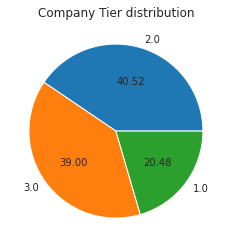

In [445]:
#Plot the pie char of clusters as per company Tiers

plt.pie(df2['Tier'].value_counts(),
        labels=df2['Tier'].value_counts().index,autopct='%.2f')
plt.title('Company Tier distribution')
plt.show()

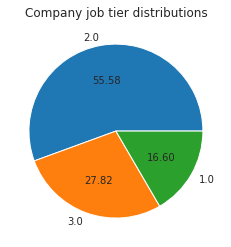

In [446]:
#Plot the pie chart of clusters as per company_job tiers

plt.pie(df2['Class'].value_counts(),
        labels=df2['Class'].value_counts().index,autopct='%.2f')
plt.title('Company job tier distributions')
plt.show()

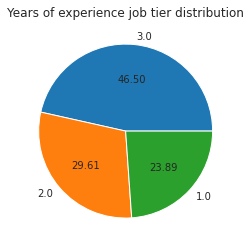

In [447]:
#Plot the pie chart of clusters as per years of exp and job tiers

plt.pie(df2['Designation'].value_counts(),
        labels=df2['Designation'].value_counts().index,autopct='%.2f')
plt.title('Years of experience job tier distribution')
plt.show()

### Questions and answers from case study

### Question1

In [448]:
#Question1:
#Top 10 employees (earning more than most of the employees in the company) - Tier 1

df2.loc[df2['Tier']==1.0].sort_values(['ctc'],ascending=False).head(10)

,company_hash,company_hash_encoded,email_hash,orgyear,ctc,job_position,job_position_encoded,ctc_updated_year,Years of Experience,Tier,Class,Designation
117551,obvqnuqxdwgb,14517.0,5b4bed51797140db4ed52018a979db1e34cee49e27b4885c3fdfacea9f8144f6,2018.0,255555555.0,NaN,409.0,2016.0,5.0,1.0,2.0,1.0
168562,xxn myhmvztofvq,33375.0,f490a63e97e46b042ef9664af701209ab41fc3995edfa77aa290d66a7fa1b5d1,2021.0,200000000.0,NaN,354.0,2019.0,2.0,1.0,2.0,1.0
82520,yaew mvzp,34760.0,1ad3d8c2b855e9cbe6bb187e8140a07ed8a8b29d275ae0cfd1dc64e63abc4693,2017.0,200000000.0,OTHER,409.0,2020.0,6.0,1.0,1.0,1.0
51586,vwwtznhqt,29134.0,2744c7f42fd4d492fa66cb2ba5168921c444dc8611ffa259d27c307ae3dbccde,2018.0,200000000.0,NaN,127.0,2019.0,5.0,1.0,1.0,1.0
30678,vwwtznhqt,29134.0,f439bb398f3d420a42f63a018ed3c5646a609c7c828388bdba9a317501853198,2020.0,200000000.0,NaN,127.0,2020.0,3.0,1.0,1.0,1.0
30545,zgzt,36098.0,c44995942d317b3a36725bf0bfb34412741fbb3583917716ce44d386060786b0,2018.0,200000000.0,ENGINEERING LEADERSHIP,212.0,2020.0,5.0,1.0,1.0,1.0
30532,nvnv wgzohrnvzwj otqcxwto,13550.0,6b779617a174319066f8c9ebe1c55740e79332c0143f2b6ecd1fed967bba17e6,2020.0,200000000.0,NaN,561.0,2020.0,3.0,1.0,2.0,2.0
82537,xwxwx mvzp,33339.0,2311bf023218afe93d650cac03abb7a40f7fa55c08d2608bc82eb37db750679f,2018.0,200000000.0,OTHER,409.0,2020.0,5.0,1.0,1.0,1.0
82547,nvnv ntrtotqcxwto rna,13506.0,e3ef9223ad1dd7385e7344270c1b1ecee22ab22da0d52c05dc7c0183ab0ed840,2010.0,200000000.0,OTHER,409.0,2020.0,13.0,1.0,2.0,1.0
18876,qtrxvzwt xzegwgbb rxbxnta,19711.0,f1b31a501f6b7fd6edae9e7e883bf60d2d3bff0fa373689491491ce75d3bc19a,2017.0,200000000.0,DATA ANALYST,165.0,2020.0,6.0,1.0,1.0,1.0


### Question2

In [449]:
#Question2:
#Top 10 employees of data science in Amazon / TCS etc earning more than their peers - Class 1

df2.loc[df2['Class']==1.0].sort_values(['ctc'],ascending=False).head(10)

,company_hash,company_hash_encoded,email_hash,orgyear,ctc,job_position,job_position_encoded,ctc_updated_year,Years of Experience,Tier,Class,Designation
52767,zgzt,36098.0,268a5aa92f0b6d0c675fc9cc1e300eb0c5930a3a139a23bc924d036bc6f3e3a5,2022.0,200000000.0,DATA SCIENTIST,173.0,2020.0,1.0,1.0,1.0,1.0
107133,ytfrtnn uvwpvqa tzntquqxot,35181.0,c888824e687a535d1bd2486ae28d67e414b21b09cbee61a4c5b273c94ad7490d,2015.0,200000000.0,DATA ANALYST,165.0,2020.0,8.0,1.0,1.0,1.0
28998,xzegojo,33823.0,d418a571a2cf09cb8cbd9eceade19381777835f58d8f98854688ca8ed09d8fe4,2018.0,200000000.0,NaN,409.0,2020.0,5.0,1.0,1.0,1.0
66300,ntlvo ztnfgqpo,12809.0,d1a0df3a5715b4582db31bcb2bef14065227c338054849d2cdaf7bbfdadafb2b,2018.0,200000000.0,ENGINEERING LEADERSHIP,212.0,2020.0,5.0,1.0,1.0,1.0
179132,xzegojo,33823.0,e1b3530381c7a3c8ccafc5195582e5880d81913862d80f3a7dc74ea26bfcd5a8,2020.0,200000000.0,NaN,409.0,2019.0,3.0,1.0,1.0,1.0
12331,nvnv wgzohrnvzwj otqcxwto,13550.0,10c67fa43291396c3f72c9ac34b99a6d9fb2c2007e6964e348cbe2ed42434c25,2018.0,200000000.0,NaN,423.0,2020.0,5.0,1.0,1.0,1.0
74502,xb v onhatzn,32487.0,431c610cffb5f699476173431bb1f47a51bcc680407e44ff511f1d03500b4307,2020.0,200000000.0,FULL STACK ENGINEER,249.0,2019.0,3.0,1.0,1.0,1.0
65906,vbvkgz,26523.0,8dfe6251bd4ec533f02ddceb98b3dcebb9550ccd4ef2e643eb3b97459cd984e5,2018.0,200000000.0,OTHER,409.0,2020.0,5.0,1.0,1.0,1.0
28898,nqvctrnqxvzsrt,12486.0,3eb73d5c74bfd5f7a195d7f56e4922a46357c6ae0a8732b11e7e0e3c26500bf7,2018.0,200000000.0,BACKEND ENGINEER,108.0,2020.0,5.0,1.0,1.0,1.0
35203,qxcxsg,20198.0,5fa750d51093a53523bde615bea27847489c2ff65874bbeeb92bba33d132ef5f,2020.0,200000000.0,OTHER,409.0,2020.0,3.0,1.0,1.0,1.0


### Question3

In [450]:
#Question3:
#Bottom 10 employees of data science in Amazon / TCS etc earning less than their peers - Class 3

df2.loc[(df2['Class']==3.0) & 
        (df2['company_hash']=='zgzt') & 
        (df2['job_position']=='DATA SCIENTIST')].sort_values(['ctc'],ascending=False).tail(10)

,company_hash,company_hash_encoded,email_hash,orgyear,ctc,job_position,job_position_encoded,ctc_updated_year,Years of Experience,Tier,Class,Designation
70263,zgzt,36098.0,cb3f313aa5ed673640f60bcfa058b96184aa0d028e199069e416af3f1f3907f0,2017.0,625000.0,DATA SCIENTIST,173.0,2020.0,6.0,3.0,3.0,3.0
97059,zgzt,36098.0,d417e55d19d79710814f9edab06a2ac2caee5088c642e0bafbc64c84113b4d6a,2018.0,600000.0,DATA SCIENTIST,173.0,2020.0,5.0,3.0,3.0,3.0
52537,zgzt,36098.0,e697c32fb2f153d9bc80bce8c2a426630231793a9f4aa1152c1ed1d5d8432d1e,2017.0,460000.0,DATA SCIENTIST,173.0,2019.0,6.0,3.0,3.0,3.0
99121,zgzt,36098.0,d96ca95effd2a14936b6edb3f19347efd04adea95c071df5fe2f353c015068f2,2021.0,420000.0,DATA SCIENTIST,173.0,2020.0,2.0,3.0,3.0,3.0
199928,zgzt,36098.0,a803adab6dde9d4b480280a4a5555676cdbb23e3e5ad8085b83a4b68c5533c78,2016.0,400000.0,DATA SCIENTIST,173.0,2020.0,7.0,3.0,3.0,3.0
29173,zgzt,36098.0,7aebe262e3cdef301d2791ccfe648c6a54177e3c9bd112fcfc4a94c0faac3a9f,2018.0,250000.0,DATA SCIENTIST,173.0,2021.0,5.0,3.0,3.0,3.0
105094,zgzt,36098.0,e13e38bf9de2dbdd8c13069e608870a5750f91e62bf71bc11d6e8c53622dd21c,2017.0,200000.0,DATA SCIENTIST,173.0,2021.0,6.0,3.0,3.0,3.0
126416,zgzt,36098.0,3377ad447408574f71ea9207a153ce85976fa86e1567d9d6221968d47c82188b,2018.0,200000.0,DATA SCIENTIST,173.0,2019.0,5.0,3.0,3.0,3.0
19696,zgzt,36098.0,6fff6aa67599055d252bd86418bae843ee46788729775484ed95d8c19a5f0662,2022.0,100000.0,DATA SCIENTIST,173.0,2020.0,1.0,3.0,3.0,3.0
45849,zgzt,36098.0,2cadff2fe2f39e9e4e684b95c0db58c9344fceb815c6c1a2429e5b453e680be0,2018.0,100000.0,DATA SCIENTIST,173.0,2020.0,5.0,3.0,3.0,3.0


### Question4

In [451]:
#Question4:
#Bottom 10 employees (earning less than most of the employees in the company)- Tier 3

df2.loc[df2['Tier']==3.0].sort_values(['ctc'],ascending=False).tail(10)

,company_hash,company_hash_encoded,email_hash,orgyear,ctc,job_position,job_position_encoded,ctc_updated_year,Years of Experience,Tier,Class,Designation
77096,vwwtznhqt,29134.0,f0f2005505c707dbdd2c86ca1587c26f822a004e86a8ec9caebc6145336fe83d,2021.0,1000.0,NaN,202.0,2019.0,2.0,3.0,3.0,3.0
133220,cxo wvqttqo,4868.0,daa966561c4087398b3c3b13855ce17adcf5e08dda803f350efd4e02103b2a45,2012.0,1000.0,ANDROID ENGINEER,25.0,2017.0,11.0,3.0,2.0,3.0
150583,zvz,37017.0,9af3dca6c9d705d8d42585ccfce2627f00e1629130d14ef814d03bd2ac256596,2023.0,600.0,NaN,243.0,2019.0,0.0,3.0,3.0,2.0
99343,gjg,7485.0,b995d7a2ae5c6f8497762ce04dc5c04ad6ec734d70802a94f83e17431884e907,2018.0,600.0,FULL STACK ENGINEER,249.0,2021.0,5.0,3.0,3.0,3.0
171084,nvnv wgzohrnvzwj otqcxwto,13550.0,80ba0259f9f59034c4927cf3bd38dc9ce2eb60ff18135bf9012feac4c1169c23,2012.0,600.0,BACKEND ENGINEER,108.0,2017.0,11.0,3.0,3.0,3.0
116863,hzxctqoxnj ge fvoyxzsngz,8644.0,f7e5e788676100d7c4146740ada9e2f8974defc01f571d34a3ff1ccf6b68c0a8,2022.0,200.0,NaN,396.0,2021.0,1.0,3.0,2.0,2.0
184820,xm,32775.0,b8a0bb340583936b5a7923947e9aec21add5ebc50cd60bf6953ea67074932d41,2016.0,15.0,NaN,155.0,2018.0,7.0,3.0,3.0,3.0
114081,xzntqcxtfmxn,34114.0,23ad96d6b6f1ecf554a52f6e9b61677c7d73d8a409a143cee85eda1557f516c8,2013.0,14.0,NaN,202.0,2018.0,10.0,3.0,1.0,3.0
118150,xzntqcxtfmxn,34114.0,f2b58aeed3c074652de2cfd3c0717a5d21d6fbcf342a786928c5fd38c860fa45,2013.0,6.0,NaN,202.0,2018.0,10.0,3.0,3.0,3.0
135344,xzntqcxtfmxn,34114.0,3505b02549ebe2c95840ac6f0a35561a3b4cbe4b79cdb15d794a6ac066b66644,2014.0,2.0,BACKEND ENGINEER,108.0,2019.0,9.0,3.0,3.0,3.0


### Question5

In [452]:
#Question5:
#Top 10 employees in Amazon- X department - 
#having 5/6/7 years of experience earning more than their peers - Tier X

df2.loc[(df2['Tier']==3.0) & 
        (df2['company_hash']=='zgzt') & 
        (df2['job_position']=='DATA SCIENTIST') &
        ((df2['Years of Experience']==5.0) |
         (df2['Years of Experience']==6.0) |
         (df2['Years of Experience']==7.0))].sort_values(['ctc'],ascending=False).tail(10)


,company_hash,company_hash_encoded,email_hash,orgyear,ctc,job_position,job_position_encoded,ctc_updated_year,Years of Experience,Tier,Class,Designation
167376,zgzt,36098.0,8502cbd83240fa8f6885606e1cc55efdcd674d9c2d0df8b96be24c98f60d067e,2017.0,649000.0,DATA SCIENTIST,173.0,2019.0,6.0,3.0,3.0,3.0
70263,zgzt,36098.0,cb3f313aa5ed673640f60bcfa058b96184aa0d028e199069e416af3f1f3907f0,2017.0,625000.0,DATA SCIENTIST,173.0,2020.0,6.0,3.0,3.0,3.0
97059,zgzt,36098.0,d417e55d19d79710814f9edab06a2ac2caee5088c642e0bafbc64c84113b4d6a,2018.0,600000.0,DATA SCIENTIST,173.0,2020.0,5.0,3.0,3.0,3.0
52537,zgzt,36098.0,e697c32fb2f153d9bc80bce8c2a426630231793a9f4aa1152c1ed1d5d8432d1e,2017.0,460000.0,DATA SCIENTIST,173.0,2019.0,6.0,3.0,3.0,3.0
199928,zgzt,36098.0,a803adab6dde9d4b480280a4a5555676cdbb23e3e5ad8085b83a4b68c5533c78,2016.0,400000.0,DATA SCIENTIST,173.0,2020.0,7.0,3.0,3.0,3.0
29173,zgzt,36098.0,7aebe262e3cdef301d2791ccfe648c6a54177e3c9bd112fcfc4a94c0faac3a9f,2018.0,250000.0,DATA SCIENTIST,173.0,2021.0,5.0,3.0,3.0,3.0
105094,zgzt,36098.0,e13e38bf9de2dbdd8c13069e608870a5750f91e62bf71bc11d6e8c53622dd21c,2017.0,200000.0,DATA SCIENTIST,173.0,2021.0,6.0,3.0,3.0,3.0
126416,zgzt,36098.0,3377ad447408574f71ea9207a153ce85976fa86e1567d9d6221968d47c82188b,2018.0,200000.0,DATA SCIENTIST,173.0,2019.0,5.0,3.0,3.0,3.0
45849,zgzt,36098.0,2cadff2fe2f39e9e4e684b95c0db58c9344fceb815c6c1a2429e5b453e680be0,2018.0,100000.0,DATA SCIENTIST,173.0,2020.0,5.0,3.0,3.0,3.0


### Question6

In [453]:
#Question6:
#Top 10 companies (based on their CTC)

df2.sort_values(['ctc'], ascending=False).head(10)

,company_hash,company_hash_encoded,email_hash,orgyear,ctc,job_position,job_position_encoded,ctc_updated_year,Years of Experience,Tier,Class,Designation
72765,whmxw rgsxwo uqxcvnt rxbxnta,30473.0,29a71dd13adf6d2d497571a565bb3096cf66cb46cd1eceeefa83817ecd4f1371,2015.0,1.000150e+09,NaN,274.0,2020.0,8.0,2.0,2.0,1.0
117551,obvqnuqxdwgb,14517.0,5b4bed51797140db4ed52018a979db1e34cee49e27b4885c3fdfacea9f8144f6,2018.0,2.555556e+08,NaN,409.0,2016.0,5.0,1.0,2.0,1.0
3295,aveegaxr xzntqzvnxgzvr hzxctqoxnj,1217.0,06d231f167701592a69cdd7d5c825a0f5b30f0347a40782e114434c5e3b5d9d6,2021.0,2.500000e+08,NaN,356.0,2020.0,2.0,2.0,2.0,1.0
72788,xeewg ngpxg stztqvr xzohqvzwt,32676.0,462f7e3dfe6c9ef8dab91e6c4650a83b6bcbe9c6b740ed555e76793f0274ec14,2019.0,2.000000e+08,NaN,275.0,2020.0,4.0,1.0,2.0,1.0
5884,xzaxv ugftq wgqugqvnxgz rna,33567.0,c9613896e32d114be30b996a9d85afe9550bab51a8a00a82043e8ed5cbd25507,2016.0,2.000000e+08,OTHER,409.0,2020.0,7.0,2.0,2.0,1.0
48997,cxcg,4796.0,e2dd499e56ff7cebd30856322f486fb6736cee7785cbb58aacba43c6a1508546,2018.0,2.000000e+08,ANDROID ENGINEER,25.0,2020.0,5.0,1.0,2.0,1.0
1240,nvnv wgzohrnvzwj otqcxwto,13550.0,82fbacc015757ee74efe763c3623dc751812af48c741ff13f4cd7315a8635c68,2015.0,2.000000e+08,NaN,409.0,2020.0,8.0,1.0,1.0,1.0
9038,zxxn ntwyzgrgsxto rxbxnta,37236.0,58e652d3e06d4228be0a8ac9ef8228928628299d93795f84d1d004f278e6e73e,2014.0,2.000000e+08,NaN,356.0,2020.0,9.0,1.0,1.0,1.0
17814,ovu,17142.0,a35a5abbe9fb056421bdd9aca4440acfb93e37c823564d952a50c40583920598,2017.0,2.000000e+08,BACKEND ENGINEER,108.0,2019.0,6.0,1.0,1.0,1.0
9062,boo,2538.0,4d899e4af4f98d23848a8e21455489231fc2cbf2ca9668a0385e7a7529cab63a,2018.0,2.000000e+08,RESEARCH ENGINEERS,493.0,2020.0,5.0,2.0,2.0,1.0


### Question7

In [454]:
#Question7:
#Top 2 positions in every company (based on their CTC)
#df2.groupby(['company_hash'])['ctc'].nlargest(2)

q_nlargest = df2.loc[df2.groupby(['company_hash'])['ctc'].nlargest(2).reset_index()['level_1']]

In [455]:
#Question7: ..contd.

q_nlargest.head(10)

,company_hash,company_hash_encoded,email_hash,orgyear,ctc,job_position,job_position_encoded,ctc_updated_year,Years of Experience,Tier,Class,Designation
2936,0,0.0,e80f7c9c26012bfdeca551e2b8642a93e45939d3d677c5287b50ef620d1e73ab,2020.0,100000.0,NaN,208.0,2020.0,3.0,2.0,2.0,3.0
16804,0,0.0,e80f7c9c26012bfdeca551e2b8642a93e45939d3d677c5287b50ef620d1e73ab,2020.0,100000.0,OTHER,409.0,2020.0,3.0,2.0,2.0,3.0
197412,0000,1.0,b3f3bb98cbca4b1ce5dfd5abb4e500ce6f6b66288a5202ead573964201d24b24,2017.0,300000.0,OTHER,409.0,2020.0,6.0,2.0,2.0,3.0
55189,01 ojztqsj,2.0,e1e15fada844f35fcc33927343d0c80f55526b87c40eeed72b25ceafc1186e5e,2011.0,830000.0,FRONT END ENGINEER,245.0,2019.0,12.0,1.0,2.0,3.0
74370,01 ojztqsj,2.0,819789ff4068fd5c8facf8a5074cdd2e1ff989c95ae02c02b81ac1447cbd6386,2016.0,270000.0,ANDROID ENGINEER,25.0,2019.0,7.0,3.0,2.0,3.0
97185,05mz exzytvrny uqxcvnt rxbxnta,3.0,4702229ffb6968c87b16fc57e730769e554184e322e1118fbd997a1d8e50dec0,2019.0,1100000.0,NaN,155.0,2021.0,4.0,2.0,2.0,2.0
139772,05mz exzytvrny uqxcvnt rxbxnta,3.0,4702229ffb6968c87b16fc57e730769e554184e322e1118fbd997a1d8e50dec0,2019.0,1100000.0,BACKEND ENGINEER,108.0,2021.0,4.0,2.0,2.0,2.0
125781,1,4.0,a0ece532f193b9e96e6bf92f133de6b2a9c20ebfb0b3bbd36a5be343d640d435,2022.0,250000.0,OTHER,409.0,2021.0,1.0,1.0,2.0,3.0
2207,1,4.0,8cc7aba49e96a0a80f7ed6c2ed79bc1d1e81171a28445c06be8a61373c139c4e,2017.0,100000.0,NaN,208.0,2020.0,6.0,3.0,2.0,3.0
163848,1 axsxnvro,5.0,70459269ec53bd863dc3bad03772c608842ce6182710e1ad40e66b1ebe578baf,2018.0,350000.0,BACKEND ENGINEER,108.0,2020.0,5.0,2.0,2.0,3.0


### Data standardization / normalization

In [456]:
#Create brand new copy of the dataframe for further proceeding

df3 = df2.drop(['company_hash', 'email_hash', 'job_position'], axis=1)

In [457]:
#Perform standardization
#User standard scaler method for normalization of the dataset values

scaler = StandardScaler()
df3_scaled = scaler.fit_transform(df3)

In [458]:
#Transform scaled data into the pandas dataframe with appropriate column names

df3_scaled = pd.DataFrame(df3_scaled, columns = df3.columns)

In [459]:
#Get the glance of the dataframe

df3_scaled.head()

,company_hash_encoded,orgyear,ctc,job_position_encoded,ctc_updated_year,Years of Experience,Tier,Class,Designation
0,-1.659614,0.017578,-0.099255,1.090037,0.280440,-0.017578,-0.247471,-1.692927,-1.517562
1,0.008642,0.049036,-0.154336,-0.021829,-0.474203,-0.049036,1.088242,1.351279,0.957894
2,-0.366344,0.001850,-0.022989,-1.001661,0.280440,-0.001850,-0.247471,-0.170824,-0.279834
3,-0.668879,0.033307,-0.133151,-1.001661,-0.474203,-0.033307,1.088242,1.351279,0.957894
4,0.052789,0.033307,-0.073833,-0.021829,-0.474203,-0.033307,-1.583184,-1.692927,-1.517562


### Cluster Tendency

##### Hopkins Statistic
Hopkins statistic is used to check the cluster tendency.
Checking cluster tendency means - checking if the data contains any inherent clusters

Statistical Method:

Hopkins statistic is used to assess clustering tendency of dataset by measuring probability that given dataset is generated by uniform data distribution. 

Hypothesis:

Null : Dataset is uniformly distributed (i.e. no clusters)

Alternate: Dataset is not uniformly distributed (i.e. there are meaningful clusters)

In [460]:
#Define function to calculate hopkins statistics 

def hopkins(dfx):
    d = dfx.shape[1]
    n = dfx.shape[0]
    m = int(0.1 * n)
    neighbors = NearestNeighbors(n_neighbors=3).fit(dfx.values)
    
    #Sample n uniform points
    dfx_random = sample(range(0, n, 1), m)
    
    ujd = []
    wjd = []
    
    for j in range(0, m):
        #Compute the distance, xi, from each real point to each nearest neighbour
        u_dist, _ = neighbors.kneighbors(np.random.uniform(np.amin(dfx,axis=0),
                                                           np.amax(dfx,axis=0),
                                                           d).reshape(1, -1), 4, return_distance=True)
        ujd.append(u_dist[0][1])
        
        #Compute the distance, yi from each artificial point to the nearest real data point
        w_dist, _ = neighbors.kneighbors(dfx.iloc[dfx_random[j]].values.reshape(1, -1),
                                         4, return_distance=True)
        wjd.append(w_dist[0][1])
    
    #Calculate the Hopkins statistic (H) as the mean nearest neighbour distance in the random dataset 
    #divided by the sum of the mean nearest neighbour distances in the real and across the simulated dataset.
    H = sum(ujd) / (sum(ujd) + sum(wjd))
  
    if math.isnan(H):
        H = 0
 
    return H

In [461]:
#If H < 0.5, then it is unlikely that D has statistically significant clusters.
#If the value of Hopkins statistic is close to 1, then we can reject the null hypothesis 
#and conclude that the dataset is significantly a clusterable data

H = hopkins(df3_scaled)

In [462]:
# The dataset in our case is highly clusterable as H is close to 1
H

0.9996657349155166

### Inference from Hopkins Statistics: 
1. Given dataset is significantly clusterable data

### Hypertuning of kmeans clustering

In [463]:
#Perform hypertuning for k clusters ranging from 1 to 9

kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(df3_scaled)
                for k in range(1, 10)]

In [464]:
#Get the inertia of each kmeans model created above

inertias = [model.inertia_ for model in kmeans_per_k]

### Elbow method

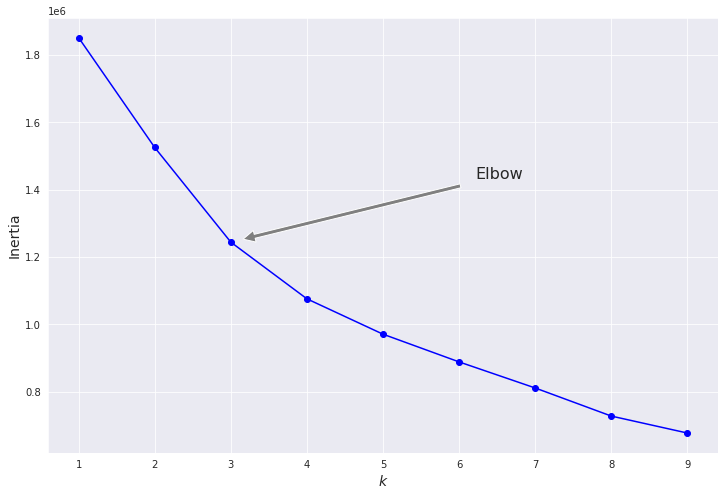

In [465]:
#Plot kmeans inertia vs k clusters ranging from 1 to 9
#This will generate a graph resembling an elbow

plt.figure(figsize=(12, 8))
plt.plot(range(1, 10), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.annotate('Elbow',
             xy=(3, inertias[2]),
             xytext=(0.55, 0.55),
             textcoords='figure fraction',
             fontsize=16,
             arrowprops=dict(facecolor='gray', shrink=0.05)
            )
#plt.grid()
plt.show()

#Inference - Elbow can be considered at 3 or 4. We are taking k=3 as elbow


### Inference from elbow method: 
1. Optimal K=3

### Preparation of kmeans model

In [492]:
#Prepare kmeans cluster model for optimal K obtained from above hypertuning

k = 3
kmeans_model = KMeans(n_clusters=k)
kmeans_model.fit(df3_scaled)

KMeans(n_clusters=3)

In [493]:
#Print cluster centers

kmeans_model.cluster_centers_

array([[-2.40218026e-02, -2.21410121e-02,  1.64870520e-01,
        -2.47803543e-02,  4.00091285e-02,  2.21410121e-02,
        -7.83031430e-01, -6.87403046e-01, -7.71038468e-01],
       [ 1.91794970e-02,  1.26863363e-02, -1.31635100e-01,
         1.97920054e-02, -3.19359812e-02, -1.26863363e-02,
         6.25195887e-01,  5.48842492e-01,  6.15620977e-01],
       [ 5.79341700e-03,  2.85479160e+02, -9.03571748e-02,
        -3.86660078e-01, -4.74202748e-01, -2.85479160e+02,
        -2.47471053e-01, -1.70824359e-01, -2.79834067e-01]])

In [494]:
#Print cluster labels

kmeans_model.labels_

array([0, 1, 0, ..., 1, 0, 1], dtype=int32)

In [495]:
#Print number of clusters

kmeans_model.n_clusters

3

In [496]:
#Predict the cluster labels using predict method

y_pred = kmeans_model.predict(df3_scaled)

In [497]:
#Display predicted labels

y_pred

array([0, 1, 0, ..., 1, 0, 1], dtype=int32)

In [498]:
#Create a brand new dataframe for further proceeding

df4 = df3_scaled.copy()

In [499]:
#Add predicted labels to the dataframe as new column

df4['label'] = kmeans_model.labels_

In [500]:
#Get a glimpse of new dataframe

df4.head()

,company_hash_encoded,orgyear,ctc,job_position_encoded,ctc_updated_year,Years of Experience,Tier,Class,Designation,label
0,-1.659614,0.017578,-0.099255,1.090037,0.280440,-0.017578,-0.247471,-1.692927,-1.517562,0
1,0.008642,0.049036,-0.154336,-0.021829,-0.474203,-0.049036,1.088242,1.351279,0.957894,1
2,-0.366344,0.001850,-0.022989,-1.001661,0.280440,-0.001850,-0.247471,-0.170824,-0.279834,0
3,-0.668879,0.033307,-0.133151,-1.001661,-0.474203,-0.033307,1.088242,1.351279,0.957894,1
4,0.052789,0.033307,-0.073833,-0.021829,-0.474203,-0.033307,-1.583184,-1.692927,-1.517562,0


### Visualization of clusters created by kmeans

In [501]:
# plt.figure(figsize=(10,6))
# pd.plotting.parallel_coordinates(df4, 'label')
# plt.show()

In [502]:
#Our clusters have 8 dimensions which can not be plotted efficiently to visualize the clusters
#So we are making effort to decompose the clusters into 2 PCA components to just see how the clusters look

pca = PCA(n_components=2)
df_pca = pca.fit_transform(df3_scaled)

In [503]:
#Convert reduced dimensional data to dataframe

df_pca = pd.DataFrame(df_pca, columns=['Component1', 'Component2'])

In [504]:
#Add new column as cluster label to the dataframe

df_pca['label'] = df4['label']

In [505]:
#Create 3 separate cluster datasets - i.e. one for each cluster

df_label0 = df_pca.loc[df_pca['label']==0]
df_label1 = df_pca.loc[df_pca['label']==1]
df_label2 = df_pca.loc[df_pca['label']==2]

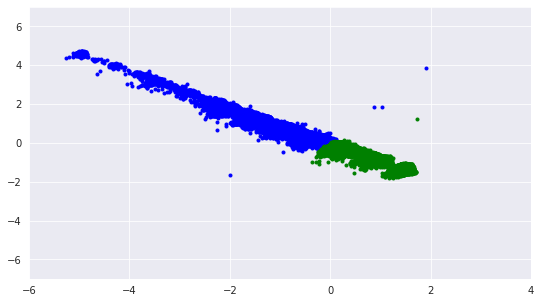

In [506]:
#Plot the PCA cluster data on 2D graph

plt.figure(figsize=(9,5))
plt.scatter(df_label0['Component1'], df_label0['Component2'],color='blue',marker='.')
plt.scatter(df_label1['Component1'], df_label1['Component2'],color='green',marker='.')
plt.scatter(df_label2['Component1'], df_label2['Component2'],color='red',marker='.')
plt.xlim(-6,4)
plt.ylim(-7,7)
#plt.grid()
plt.show()

#Inference -
#1. Cluster 0 and 1 are vividly visible and showing fairly good amount of values within it
#2. However cluster 2 is not visible at all and that means there are very very less values in cluster 2

In [507]:
#Value counts of kmeans generated clusters

df4['label'].value_counts()

#Inference - The data is majorly categorized into the two clusters and not 3


1    114383
0     91328
2         2
Name: label, dtype: int64

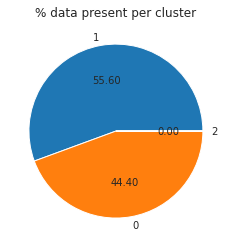

In [567]:
#Visual display of amount of data in 2 clusters

t = df4['label'].value_counts()
plt.pie(t, labels=t.index, autopct='%.2f')
plt.title('% data present per cluster')
plt.show()

### Comparison manual clusters with kmeans clusters

In [508]:
#Compare the manual clustering vs kmeans clustering

df5 = df3.copy()
df5['label'] = kmeans_model.labels_

In [509]:
cluster0 = df5.loc[df5['label']==0]
cluster1 = df5.loc[df5['label']==1]
cluster2 = df5.loc[df5['label']==2]

Tier: % Of manual clusters matching with kmeans cluster 0 for Company Tier


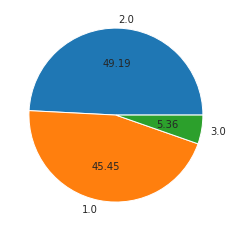


Class: % Of manual clusters matching with kmeans cluster 0 for Company job position Tier


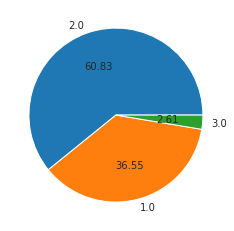


Designation: % Of manual clusters matching with kmeans cluster 0 for Years of exp job position Tier


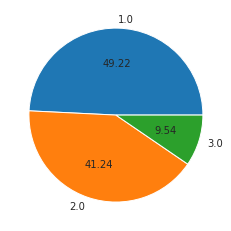

In [514]:
#Check which manual cluster has how much percentage of matching with the kmeans cluster 0

print('Tier: % Of manual clusters matching with kmeans cluster 0 for Company Tier')
x = cluster0['Tier'].value_counts()/cluster0.shape[0]*100
plt.pie(x, labels=x.index, autopct='%.2f')
plt.show()
print()

print('Class: % Of manual clusters matching with kmeans cluster 0 for Company job position Tier')
y = cluster0['Class'].value_counts()/cluster0.shape[0]*100
plt.pie(y, labels=y.index, autopct='%.2f')
plt.show()

print()
print('Designation: % Of manual clusters matching with kmeans cluster 0 for Years of exp job position Tier')
z = cluster0['Designation'].value_counts()/cluster0.shape[0]*100
plt.pie(z, labels=z.index, autopct='%.2f')
plt.show()

#Inference - 
#Manual clusters and kmeans cluster 0 doesn't have a great match. Highest percentage of match is 60%
#Manual Cluster 2.0 and Kmeans cluster 0 has highest number of matches for Class Tier

### Inference: 
1. Manual cluster 2.0 created based on company and job position seems to have 60% match with kmeans cluster 0

Tier: % Of manual clusters matching with kmeans cluster 1 for Company Tier


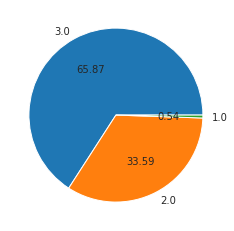


Class: % Of manual clusters matching with kmeans cluster 1 for Company job position Tier


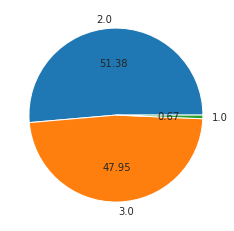


Designation: % Of manual clusters matching with kmeans cluster 1 for Years of exp job position Tier


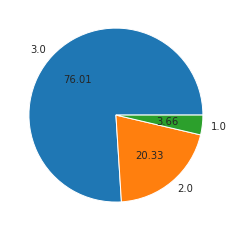

In [515]:
#Check which manual cluster has how much percentage of matching with the kmeans cluster 1

print('Tier: % Of manual clusters matching with kmeans cluster 1 for Company Tier')
x = cluster1['Tier'].value_counts()/cluster1.shape[0]*100
plt.pie(x, labels=x.index, autopct='%.2f')
plt.show()
print()

print('Class: % Of manual clusters matching with kmeans cluster 1 for Company job position Tier')
y = cluster1['Class'].value_counts()/cluster1.shape[0]*100
plt.pie(y, labels=y.index, autopct='%.2f')
plt.show()

print()
print('Designation: % Of manual clusters matching with kmeans cluster 1 for Years of exp job position Tier')
z = cluster1['Designation'].value_counts()/cluster1.shape[0]*100
plt.pie(z, labels=z.index, autopct='%.2f')
plt.show()

#Inference - 
#Manual Cluster 3.0 and Kmeans cluster 1 has highest number of matches for Designation Tier
#So Kmeans cluster 1 seems to be almost similar to manual cluster 3.0 created based on years of exp and job

### Inference: 
1. Manual cluster 3.0 created based on years of exp and job position seems to match with kmeans cluster 1

Tier: % Of manual clusters matching with kmeans cluster 2 for Company Tier


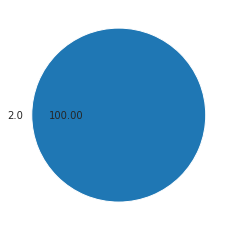


Class: % Of manual clusters matching with kmeans cluster 2 for Company job position Tier


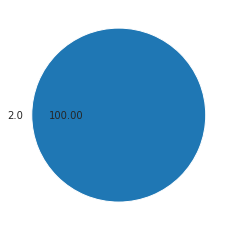


Designation: % Of manual clusters matching with kmeans cluster 2 for Years of exp job position Tier


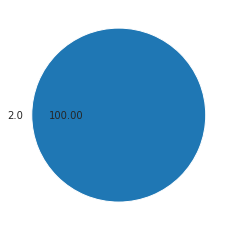

In [516]:
#Check which manual cluster has how much percentage of matching with the kmeans cluster 2

print('Tier: % Of manual clusters matching with kmeans cluster 2 for Company Tier')
x = cluster2['Tier'].value_counts()/cluster2.shape[0]*100
plt.pie(x, labels=x.index, autopct='%.2f')
plt.show()
print()

print('Class: % Of manual clusters matching with kmeans cluster 2 for Company job position Tier')
y = cluster2['Class'].value_counts()/cluster2.shape[0]*100
plt.pie(y, labels=y.index, autopct='%.2f')
plt.show()

print()
print('Designation: % Of manual clusters matching with kmeans cluster 2 for Years of exp job position Tier')
z = cluster2['Designation'].value_counts()/cluster2.shape[0]*100
plt.pie(z, labels=z.index, autopct='%.2f')
plt.show()

#Inference - 
#Manual clusters and kmeans cluster 2 doesn't have a match at all. Highest percentage of match is 0%
#This is because kmeans clustering categorized the data into two clusters and third cluster has only 2 pts

### Inference: 
1. There is no match for kmeans cluster 2 with any of the manually created clusters. 
2. This is because kmeans clusters has categorized the data majorly into 2 clusters
3. And the third cluster has only 2 points. 
4. This gives us the sense that the manual clusters that we have created might be be the perfect clusters. 
5. Also there would need a higher amount of data cleaning and proper aligment to make more accurate and sensible clusters.

50th percentile:
ctc of cluster 0:  1700000.0
ctc of cluster 1:  600000.0
------------------------------------------------------------------------
25th percentile:
ctc of cluster 0:  1100000.0
ctc of cluster 1:  400000.0
------------------------------------------------------------------------
75th percentile:
ctc of cluster 0:  2600000.0
ctc of cluster 1:  900000.0
------------------------------------------------------------------------


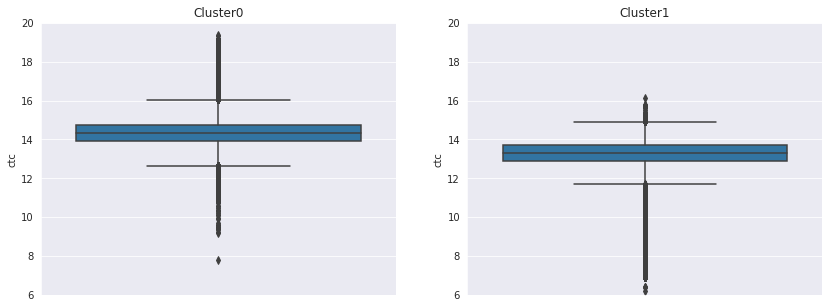

In [517]:
#Salaries of Kmeans clusters 0 and 1 for different quantiles

print('50th percentile:')
print('ctc of cluster 0: ',np.percentile(cluster0['ctc'],50))
print('ctc of cluster 1: ',np.percentile(cluster1['ctc'],50))
print('------------------------------------------------------------------------')
print('25th percentile:')
print('ctc of cluster 0: ',np.percentile(cluster0['ctc'],25))
print('ctc of cluster 1: ',np.percentile(cluster1['ctc'],25))
print('------------------------------------------------------------------------')
print('75th percentile:')
print('ctc of cluster 0: ',np.percentile(cluster0['ctc'],75))
print('ctc of cluster 1: ',np.percentile(cluster1['ctc'],75))
print('------------------------------------------------------------------------')

plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
sns.boxplot(y=np.log(cluster0['ctc']))
plt.ylim(6,20)
plt.title('Cluster0')

plt.subplot(1,2,2)
sns.boxplot(y=np.log(cluster1['ctc']))
plt.ylim(6,20)
plt.title('Cluster1')
plt.show()

In [530]:
#Get job positions baed on top 10 CTC in cluster 0

print('Top job positions in cluster 0: ')
print()
t = cluster0.sort_values(['ctc'],ascending=False)['job_position_encoded'].head(10).unique()
t = df2.loc[df2['job_position_encoded'].isin(t)]['job_position'].dropna().unique()
for i in t:
    print(i)

Top job positions in cluster 0: 

OTHER
FULL STACK ENGINEER
BACKEND ENGINEER
FRONT END ENGINEER
MEMBER OF TECHNICAL STAFF IV
INSURANCE AGENT


In [531]:
#Get job positions based on top 10 CTC in cluster 1

print('Top job positions in cluster 1: ')
print()
t = cluster1.sort_values(['ctc'],ascending=False)['job_position_encoded'].head(10).unique()
t = df2.loc[df2['job_position_encoded'].isin(t)]['job_position'].dropna().unique()
for i in t:
    print(i)

Top job positions in cluster 1: 

OTHER
FULL STACK ENGINEER
BACKEND ENGINEER
QA ENGINEER
DATA SCIENTIST
COMPUTER SCIENTIST II


In [532]:
#Get job positions based on bottom 10 CTC in cluster 0

print('Bottom job positions in cluster 0: ')
print()
t = cluster0.sort_values(['ctc'],ascending=False)['job_position_encoded'].tail(10).unique()
t = df2.loc[df2['job_position_encoded'].isin(t)]['job_position'].dropna().unique()
for i in t:
    print(i)

Bottom job positions in cluster 0: 

FULL STACK ENGINEER
BACKEND ENGINEER
IOS ENGINEER
DATA SCIENTIST
PDP EXECUTIVE
FIBRE ENGINEER
RESEARCH ASSISTANT
CORE ENGINEER SOFTWARE DEVELOPER


In [533]:
#Get job positions based on bottom 10 CTC in cluster 1

print('Bottom job positions in cluster 1: ')
print()
t = cluster1.sort_values(['ctc'],ascending=False)['job_position_encoded'].tail(10).unique()
t = df2.loc[df2['job_position_encoded'].isin(t)]['job_position'].dropna().unique()
for i in t:
    print(i)

Bottom job positions in cluster 1: 

OTHER
BACKEND ENGINEER
ANDROID ENGINEER
COFOUNDER
DATABASSISTANT SYSTEM ENGINEER ADMINISTRATOR
NULL
EMBEDDED SOFTWARE DEVELOPMENT ENGINEER
CORE ENGINEER SOFTWARE DEVELOPER


In [534]:
#Get companies based on top 10 CTC in cluster 0

print('Top companies in cluster 0: ')
print()
t = cluster0.sort_values(['ctc'],ascending=False)['company_hash_encoded'].head(10).unique()
t = df2.loc[df2['company_hash_encoded'].isin(t)]['company_hash'].dropna().unique()
for i in t:
    print(i)

Top companies in cluster 0: 

wgzwtznqxd
vbagwo
vrnqvz
bxwqgogen
vao ogrhnxgz
aveegaxr xzntqzvnxgzvr hzxctqoxnj
zgn jtn fgqpxzsx vb onxrr onhajxzs
guug bgmxrto
obvqnuqxdwgb
whmxw rgsxwo uqxcvnt rxbxnta


In [535]:
#Get companies based on top 10 CTC in cluster 1

print('Top companies in cluster 1: ')
print()
t = cluster1.sort_values(['ctc'],ascending=False)['company_hash_encoded'].head(10).unique()
t = df2.loc[df2['company_hash_encoded'].isin(t)]['company_hash'].dropna().unique()
for i in t:
    print(i)

Top companies in cluster 1: 

mqxwponttr tzntquqxoto uqxcvnt rxbxnta
wvqttb
vabxzxonqvnt
orxwt
cvyvz xzw
xzagqot unt rna


In [536]:
#Get companies based on bottom 10 CTC in cluster 0

print('Bottom companies in cluster 0: ')
print()
t = cluster0.sort_values(['ctc'],ascending=False)['company_hash_encoded'].tail(10).unique()
t = df2.loc[df2['company_hash_encoded'].isin(t)]['company_hash'].dropna().unique()
for i in t:
    print(i)

Bottom companies in cluster 0: 

exznqhon ogrhnxgzo ucn rna
uqtu ntwyzgrgsxto
hzxctqoxnj ge xrrxzgxo vn wyxwvsg
hzxctqoxnj ge yghongz wn mvhtq wgrrtst ge mhoxztoo
mlxn
axsxpvrv
mrxzp22
gutzoggi
zgqot axsxnvr
xm


In [537]:
#Get companies based on bottom 10 CTC in cluster 1

print('Bottom companies in cluster 1: ')
print()
t = cluster1.sort_values(['ctc'],ascending=False)['company_hash_encoded'].tail(10).unique()
t = df2.loc[df2['company_hash_encoded'].isin(t)]['company_hash'].dropna().unique()
for i in t:
    print(i)

Bottom companies in cluster 1: 

nvnv wgzohrnvzwj otqcxwto
xzntqcxtfmxn
hzxctqoxnj ge fvoyxzsngz
uqvpqxnx voogwxvnto
uqgmrtb ogrcxzs
ftm ongqt
vcvzn sqghu
xm


### Hierarchical Clustering

In [541]:
#Create a brand new copy of dataframe for further proceedings. Get sample of 2000 points

df6 = df3.copy()
df6_sample = df6.sample(2000)

In [542]:
#Perform standardization of data

df6_sample_scaled = scaler.fit_transform(df6_sample)
df6_sample_scaled = pd.DataFrame(df6_sample_scaled, columns=df6_sample.columns)

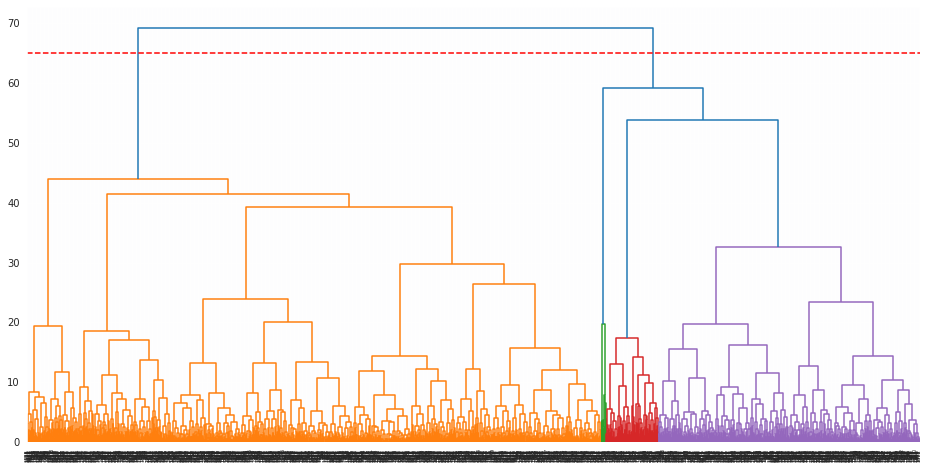

In [543]:
#Plot Dendogram 

plt.figure(figsize=(16,8))
linkage_data = linkage(df6_sample_scaled, method='ward', metric='euclidean')
dendrogram(linkage_data)
plt.xticks(rotation=90)
plt.axhline(y=65, color='r', linestyle='--')
plt.show()

#Inference from dendogram: 
#We will brodly consider 2 clusters and hence we have put the line cutting the dendogram at 2 points

### Inference from dendogram: 
1. We will consider 2 clusters for hierarchical / agglomerative clustering. Red line cutting dendogram at 2 points suggests the same

In [544]:
#Create hierarchical clustering model using agglomerative clustering method

hier_clust_model = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward')
hier_clust_model.fit(df6_sample_scaled)

AgglomerativeClustering()

In [545]:
#Print number of clusters

hier_clust_model.n_clusters

2

In [546]:
#Predict the hierarchical clustering labels

y_pred = hier_clust_model.fit_predict(df6_sample_scaled)

In [547]:
#Add label column to the sample dataframe

df6_sample['label'] = y_pred

In [548]:
df6_sample.head()

,company_hash_encoded,orgyear,ctc,job_position_encoded,ctc_updated_year,Years of Experience,Tier,Class,Designation,label
133450,29134.0,2020.0,940000.0,108.0,2021.0,3.0,2.0,2.0,2.0,0
47592,31794.0,2015.0,440000.0,245.0,2018.0,8.0,3.0,3.0,3.0,1
193725,5716.0,2020.0,1150000.0,356.0,2020.0,3.0,2.0,2.0,1.0,0
191502,3461.0,2017.0,900000.0,108.0,2020.0,6.0,1.0,1.0,3.0,0
314,29525.0,2012.0,1500000.0,108.0,2021.0,11.0,2.0,2.0,3.0,1


Distribution of points per cluster


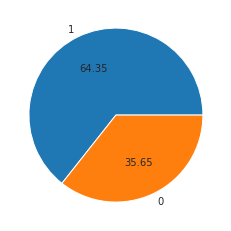

In [554]:
#Check the percentage of values per cluster

print('Distribution of points per cluster')
x = df6_sample['label'].value_counts()
plt.pie(x, labels=x.index, autopct='%.2f')
plt.show()

#Inference: 
#Cluster 0 got 35.65% of data
#Cluster 1 got 64.35% of data

In [555]:
#Filter the hierarchical clusters into separate datasets

hier_label_0 = df6_sample.loc[df6_sample['label']==0]
hier_label_1 = df6_sample.loc[df6_sample['label']==1]

Tier: % Of manual clusters matching with hierarchical cluster 0 for Company Tier


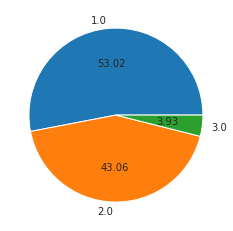


Class: % Of manual clusters matching with hierarchical cluster 0 for Company job position Tier


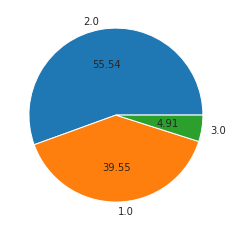


Designation: % Of manual clusters matching with hierarchical cluster 0 for Years of exp job position Tier


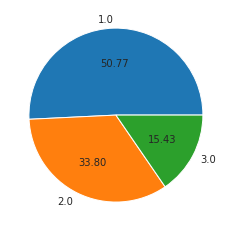

In [557]:
#Check which manual cluster has how much percentage of matching with the hierarchical cluster 0

print('Tier: % Of manual clusters matching with hierarchical cluster 0 for Company Tier')
x = hier_label_0['Tier'].value_counts()/hier_label_0.shape[0]*100
plt.pie(x, labels=x.index, autopct='%.2f')
plt.show()
print()

print('Class: % Of manual clusters matching with hierarchical cluster 0 for Company job position Tier')
y = hier_label_0['Class'].value_counts()/hier_label_0.shape[0]*100
plt.pie(y, labels=y.index, autopct='%.2f')
plt.show()

print()
print('Designation: % Of manual clusters matching with hierarchical cluster 0 for Years of exp job position Tier')
z = hier_label_0['Designation'].value_counts()/hier_label_0.shape[0]*100
plt.pie(z, labels=z.index, autopct='%.2f')
plt.show()

#Inference - 
#Manual Cluster 1.0, 2.0 & 3.0 and hierarchical cluster 0 has almost similar number of matches 
#for Tier, Class & Desitnation Tier

Tier: % Of manual clusters matching with hierarchical cluster 1 for Company Tier


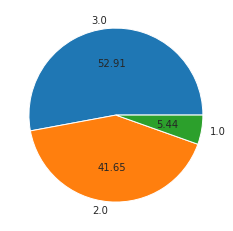


Class: % Of manual clusters matching with hierarchical cluster 1 for Company job position Tier


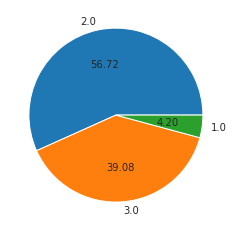


Designation: % Of manual clusters matching with hierarchical cluster 1 for Years of exp job position Tier


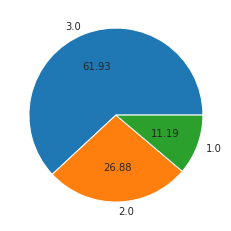

In [559]:
#Check which manual cluster has how much percentage of matching with the hierarchical cluster 1

print('Tier: % Of manual clusters matching with hierarchical cluster 1 for Company Tier')
x = hier_label_1['Tier'].value_counts()/hier_label_1.shape[0]*100
plt.pie(x, labels=x.index, autopct='%.2f')
plt.show()
print()

print('Class: % Of manual clusters matching with hierarchical cluster 1 for Company job position Tier')
y = hier_label_1['Class'].value_counts()/hier_label_1.shape[0]*100
plt.pie(y, labels=y.index, autopct='%.2f')
plt.show()

print()
print('Designation: % Of manual clusters matching with hierarchical cluster 1 for Years of exp job position Tier')
z = hier_label_1['Designation'].value_counts()/hier_label_1.shape[0]*100
plt.pie(z, labels=z.index, autopct='%.2f')
plt.show()

#Inference - 
#Manual Clusters 1.0, 2.0 & 3.0 and hierarchical cluster 1 has almost similar number of matches 
#for Tier, Class & Designation

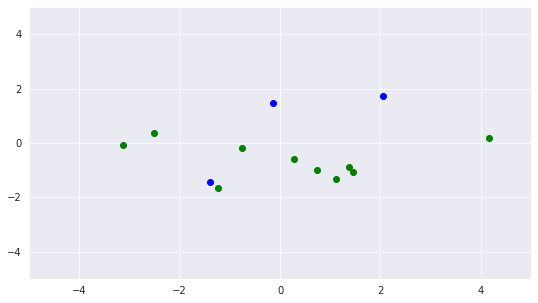

In [561]:
#Let's try to do the PCA of hierarchical clusters and let's try to plot those

pca = PCA(n_components=2)
df6_pca = pca.fit_transform(df6_sample_scaled)

df6_pca = pd.DataFrame(df6_pca, columns=['Component1', 'Component2'])
df6_pca['label'] = df6_sample['label']

df6_label0 = df6_pca.loc[df6_pca['label']==0]
df6_label1 = df6_pca.loc[df6_pca['label']==1]

plt.figure(figsize=(9,5))
plt.scatter(df6_label0['Component1'], df6_label0['Component2'],color='blue',marker='o')
plt.scatter(df6_label1['Component1'], df6_label1['Component2'],color='green',marker='o')
plt.xlim(-5,5)
plt.ylim(-5,5)
#plt.grid()
plt.show()

#Inference:
#1. Since the random sample was small, clusters formed are not very dense and are not interpretable

50th percentile:
ctc of cluster 0:  1810000.0
ctc of cluster 1:  700000.0
------------------------------------------------------------------------
25th percentile:
ctc of cluster 0:  1200000.0
ctc of cluster 1:  445000.0
------------------------------------------------------------------------
75th percentile:
ctc of cluster 0:  2900000.0
ctc of cluster 1:  1100000.0
------------------------------------------------------------------------


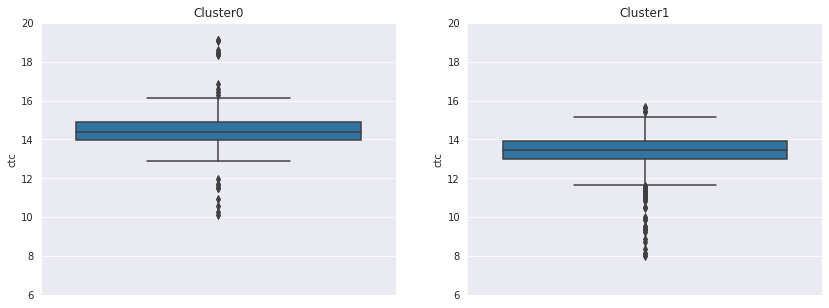

In [562]:
#Salaries of Hierarchical clusters 0 and 1 for different quantiles

print('50th percentile:')
print('ctc of cluster 0: ',np.percentile(hier_label_0['ctc'],50))
print('ctc of cluster 1: ',np.percentile(hier_label_1['ctc'],50))
print('------------------------------------------------------------------------')
print('25th percentile:')
print('ctc of cluster 0: ',np.percentile(hier_label_0['ctc'],25))
print('ctc of cluster 1: ',np.percentile(hier_label_1['ctc'],25))
print('------------------------------------------------------------------------')
print('75th percentile:')
print('ctc of cluster 0: ',np.percentile(hier_label_0['ctc'],75))
print('ctc of cluster 1: ',np.percentile(hier_label_1['ctc'],75))
print('------------------------------------------------------------------------')

plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
sns.boxplot(y=np.log(hier_label_0['ctc']))
plt.ylim(6,20)
plt.title('Cluster0')

plt.subplot(1,2,2)
sns.boxplot(y=np.log(hier_label_1['ctc']))
plt.ylim(6,20)
plt.title('Cluster1')
plt.show()

### Actionable Insights and Recommendations

**Observations :**

    (a) Hopkins statistics test proves that the given dataset is significantly clusterable.
        So it makes perfect sense to implement clustering on the given dataset.

    (b) Kmeans clustering has categorized the data into 2 clusters - High CTC and Low CTC.

    (c) CTC numbers of both the clusters are significantly different than each other.

**Insights from Cluster 0 (High CTC Cluster):**

    (a) 50th percentile CTC is: 1700K
    (b) 25th percentile CTC is: 1100K
    (c) 75th percentile CTC is: 2600K


**Insights from Cluster 1 (Low CTC Cluster):**

    (a) 50th percentile CTC is: 600K
    (b) 25th percentile CTC is: 400K
    (c) 75th percentile CTC is: 900K
    
    
**Percentage of Data per cluster :**

    (a) High CTC Cluster: 44%
    (b) Low CTC Cluster: 56%
    
**Job positions based on top 10 CTC :**

    (a) High CTC Cluster:
            . OTHER
            . FULL STACK ENGINEER
            . BACKEND ENGINEER
            . FRONT END ENGINEER
            . MEMBER OF TECHNICAL STAFF IV
            . INSURANCE AGENT
    
    (b) Low CTC Cluster:
            . OTHER
            . FULL STACK ENGINEER
            . BACKEND ENGINEER
            . QA ENGINEER
            . DATA SCIENTIST
            . COMPUTER SCIENTIST II

**Job positions based on bottom 10 CTC :**

    (a) High CTC Cluster:
            . FULL STACK ENGINEER
            . BACKEND ENGINEER
            . IOS ENGINEER
            . DATA SCIENTIST
            . PDP EXECUTIVE
            . FIBRE ENGINEER
            . RESEARCH ASSISTANT
            . CORE ENGINEER SOFTWARE DEVELOPER
    
    (b) Low CTC Cluster:
            . OTHER
            . BACKEND ENGINEER
            . ANDROID ENGINEER
            . COFOUNDER
            . DATABASSISTANT SYSTEM ENGINEER ADMINISTRATOR
            . NULL
            . EMBEDDED SOFTWARE DEVELOPMENT ENGINEER
            . CORE ENGINEER SOFTWARE DEVELOPER

**Companies based on top 10 CTC :**

    (a) High CTC Cluster:
            . wgzwtznqxd
            . vbagwo
            . vrnqvz
            . bxwqgogen
            . vao ogrhnxgz
            . aveegaxr xzntqzvnxgzvr hzxctqoxnj
            . zgn jtn fgqpxzsx vb onxrr onhajxzs
            . guug bgmxrto
            . obvqnuqxdwgb
            . whmxw rgsxwo uqxcvnt rxbxnta

    (b) Low CTC Cluster:
            . mqxwponttr tzntquqxoto uqxcvnt rxbxnta
            . wvqttb
            . vabxzxonqvnt
            . orxwt
            . cvyvz xzw
            . xzagqot unt rna

**Companies based on bottom 10 CTC :**

    (a) High CTC Cluster:
            . exznqhon ogrhnxgzo ucn rna
            . uqtu ntwyzgrgsxto
            . hzxctqoxnj ge xrrxzgxo vn wyxwvsg
            . hzxctqoxnj ge yghongz wn mvhtq wgrrtst ge mhoxztoo
            . mlxn
            . axsxpvrv
            . mrxzp22
            . gutzoggi
            . zgqot axsxnvr
            . xm

    (b) Low CTC Cluster:
            . nvnv wgzohrnvzwj otqcxwto
            . xzntqcxtfmxn
            . hzxctqoxnj ge fvoyxzsngz
            . uqvpqxnx voogwxvnto
            . uqgmrtb ogrcxzs
            . ftm ongqt
            . vcvzn sqghu
            . xm

### Actionable Recommendations

**Nomenclature :** 
    
    (a) High CTC Cluster --> HCC
    (b) Low CTC Cluster --> LCC

**Recommendations :**

    (a) LCC contains 56% of the total data from the given dataset.
    (b) Professionals from LCC should be the primary target for the enrollments into the upskilling programs.
    (c) 75th percentile of CTC of LCC is lower than the 25th percentile of HCC. So, these can be good targets.
    (d) Easiest targets are job positions and companies based on bottom 10 CTC of LCC. These are listed above.
    (e) Recommendations of companies or combination of companies & job_positions from HCC to LCC won't make 
        much sense and should be avoided unless thouroghly checked for reliable options.
    (f) 50% of professionals from HCC lying below 50th percentile of CTC are also good target for 
        upskilling programs offering improvement on their current CTC.
    (g) Professionals from LCC with higher years of experience are good targets becuase designation class i.e.
        (Years of exp and job position) has significant impact on clustering and almost 76% are found in 
        tier 3 which is less than median CTC.
    (h) Understand the highiring practises of the companies from HCC and what are the expertise expected by
        them. The curriculum should be crafted meticulously to achieve the benchmark of these companies.
    (i) Understand and study the roles and responsibilities of high CTC job positions in HCC. Setup the
        benchmark accordingly for assignments, case studies, mock interviews and exit tests.
    (j) CTC numbers, company names, job positions for HCC and LCC are mentioned above as observations.
        Business can refer to that information to draw the inferences.